#**Thermal comfort standards: a comparison between Brazil and North America**

This notebook presents the data analysis made for the paper "Thermal comfort provision in naturally ventilated buildings: a comparison between Brazil and North American standards".

We evaluated the temperature behavior for the eight bioclimatic zones in Brazil. Our goal was to determine if the temperatures were inside the applicable temperatures for the [ASHRAE 55](https://www.ashrae.org/technical-resources/bookstore/standard-55-thermal-environmental-conditions-for-human-occupancy) adaptative model (between $10^{\circ}C$ and $33.5^{\circ}C$). 

We also computed the 80% acceptability temperature limits, given by:

$$upper_{80} = 0.31*\overline{t_{pma(out)}} + 21.3$$

$$lower_{80} = 0.31*\overline{t_{pma(out)}} + 14.3$$

where $\overline{t_{pma(out)}}$ is the running mean of the outdoor temperature.

We used a period of 7 days to compute the running mean and the function from the [pythermalcomfort library](https://pypi.org/project/pythermalcomfort/).

The data used was extracted from the [INMET database](https://bdmep.inmet.gov.br/). We used the period between 2019 and 2021 for all the stations available, and divided the data between the [8 bioclimatic zones](https://www.abntcatalogo.com.br/norma.aspx?Q=aXVWUnIvNmh2TStycVVzWFlvQTlyb0hhaVo3NDBFRk8=).





For each of the climatic zones, this notebook presents:

- plot with minimum, maximum and mean temperature
- plot with running mean and the limits $10^{\circ}C$ and $33.5^{\circ}C$
- percentage of days the temperature was within this limits, below or above
- percentage of days the running mean was within this limits, below or above, stratified by season 
- plot with upper and lower 80% limits
- comparison between ASHRAE 55 and ABNT NBR 15575-1 limits for thermal comfort
- descriptive of all zone metrics

The markers are the data from each city and the lines the mean for the bioclimatic zone.

We also present the plots for the 8 zones consolidated and a general descriptive.

##**Libraries**

In [ ]:
pip install https://github.com/CenterForTheBuiltEnvironment/pythermalcomfort/archive/master.zip

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import io
import seaborn as sns
sns.set()
sns.set_style("whitegrid")

import pythermalcomfort as tc

import time
import datetime as dt
import glob

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import PercentFormatter
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

from google.colab import drive
from google.colab import files

#mount google drive
from google.colab import drive
drive.mount('/content/drive')

##**Functions**

In [3]:
#compile data from all cities into a single dataframe
def get_files(zone):
  list_files = glob.glob(f'/Zone {zone}/***.xlsx')
  df =  pd.DataFrame()
  
  for f in list_files:
    temp = pd.read_excel(f)[10:]
    temp = temp.set_axis(['DATE','TMAX','TMEAN','TMIN'], axis=1, inplace=False)
    
    #compute running mean (function from pythermalcomfort)
    temp['RUNNING_MEAN'] = temp['TMEAN'].rolling(7).apply(tc.utilities.running_mean_outdoor_temperature)
    temp = temp[~temp['RUNNING_MEAN'].isnull()] #discard days without enough info to compute the running mean
    
    df = df.append(temp) #append file to dataframe

  df[['TMEAN','TMAX','TMIN']] = df[['TMEAN','TMAX','TMIN']].astype(float) #convert to float  
  df['DATE'] = pd.to_datetime(df['DATE']) #convert to datetime

  #create new dataframe with the mean value for each zone
  df_new = df.groupby('DATE').mean()
  df_new = df_new.reset_index()

  return df, df_new

#plot minimum, mean and maximum temperature for the zone
def plot_temp(complete,mean,zone):
  plt.figure(figsize=(15,6))
  plt.plot(mean['DATE'], mean['TMEAN'], color='orange',label='Mean temperature')
  plt.plot(mean['DATE'], mean['TMAX'], color='salmon',label='Maximum temperature')
  plt.plot(mean['DATE'], mean['TMIN'], color='lightskyblue',label='Minimum temperature')
  plt.title(f'Temperatures of Zone {zone}',fontsize=25)
  plt.xlabel('Date')
  plt.ylabel('Temperature')
  plt.legend(loc='lower right')
  plt.show

#get percentage of days the temperature is in each interval
def get_pct(data):
  #auxiliar lists
  between = []
  above = []
  below = []
  columns = ['TMEAN','RUNNING_MEAN','TMIN','TMAX']
  
  for c in columns:
    between.append(round((len(data[(data[c]>=10) & (data[c]<=33.5)])/len(data[~data[c].isnull()]))*100,2))
    below.append(round((len(data[data[c]<10])/len(data[~data[c].isnull()]))*100,2))
    above.append(round((len(data[data[c]>33.5])/len(data[~data[c].isnull()]))*100,2))

  #dataframe for results
  table = pd.DataFrame()
  table.index = columns
  table['above 10C and below 33.5C (%)'] = between
  table['below 10C (%)'] = below
  table['above 33.5C (%)'] = above

  return table

#get temperature descriptive per season
def get_season(data):
  # aux lists
  summer = [12,1,2]
  autumn = [3,4,5]
  winter = [6,7,8]
  spring = [9,10,11]

  #create classification for season
  data['Month'] = data['DATE'].dt.strftime('%m').astype(int)
  data.loc[data['Month'].isin(summer), 'Season'] = 'Summer'
  data.loc[data['Month'].isin(autumn), 'Season'] = 'Autumn'
  data.loc[data['Month'].isin(winter), 'Season'] = 'Winter'
  data.loc[data['Month'].isin(spring), 'Season'] = 'Spring'

  between = []
  above = []
  below = []
  seasons = ['Summer','Autumn','Winter','Spring']
  for s in seasons:
    aux = data[data['Season']==s]
    between.append(round((len(aux[(aux['RUNNING_MEAN']>=10) & (aux['RUNNING_MEAN']<=33.5)])/len(data[~data['RUNNING_MEAN'].isnull()]))*100,2))
    below.append(round((len(aux[aux['RUNNING_MEAN']<10])/len(data[~data['RUNNING_MEAN'].isnull()]))*100,2))
    above.append(round((len(aux[aux['RUNNING_MEAN']>33.5])/len(data[~data['RUNNING_MEAN'].isnull()]))*100,2))

  #dataframe for results
  table = pd.DataFrame()
  table.index = seasons
  table['above 10C and below 33.5C (%)'] = between
  table['below 10C (%)'] = below
  table['above 33.5C (%)'] = above

  print("Distribution of the running mean for each season")
  return table

#plot running mean for all cities and the for the zone (with lines for 10C and 33.5C)
def plot_scatter_temp(data_complete,data,zone):
  plt.figure(figsize=(15,6))
  plt.axhline(33.5,color='salmon',label='33.5C')
  plt.axhline(10,color='lightskyblue',label='10C')
  plt.scatter(data_complete['DATE'], data_complete['RUNNING_MEAN'], color='lightgreen',s=5,label='Running mean temperatures of cities')
  plt.plot(data['DATE'], data['RUNNING_MEAN'], color='seagreen',label='Running mean temperature of zone')
  plt.xlim(data.DATE.iloc[0], data.DATE.iloc[-1])
  plt.title(f'Running mean of zone {zone}',fontsize=25)
  plt.xlabel('Date')
  plt.ylabel('Temperature')
  plt.legend(loc='lower right')
  plt.show

#get the 80% acceptability limits
def get_limits(data,column):
  data['upper_80'] = 0.31*data[column] + 21.3
  data['lower_80'] = 0.31*data[column] + 14.3
  return data

#plot the 80% accepatability limits for each city and for the zone
def plot_limits_scatter(data_complete,data,zone):
  plt.figure(figsize=(15,6))
  plt.scatter(data_complete['DATE'], data_complete['upper_80'], color='salmon',s=5,label='Upper 80% acceptability limits of cities')
  plt.scatter(data_complete['DATE'], data_complete['lower_80'], color='lightblue',s=5,label='Lower 80% acceptability limits of cities')
  plt.plot(data['DATE'], data['upper_80'], color='lightcoral',label='Upper 80% acceptability limits of the zone')
  plt.plot(data['DATE'], data['lower_80'], color='deepskyblue',label='Lower 80% acceptability limits of the zone')
  d = mean1['DATE'].values
  plt.fill_between(d, data['upper_80'], data['lower_80'],
                where=data['upper_80'] >= data['lower_80'],
                facecolor='lightgray',alpha=0.7)
  plt.title(f'80% acceptability limits for Zone {zone}',fontsize=25)
  plt.xlabel('Date')
  plt.ylabel('Temperature limit')
  plt.legend(loc='lower right')
  plt.show

##**Zone 1**

In [67]:
complete1,mean1 = get_files(1)

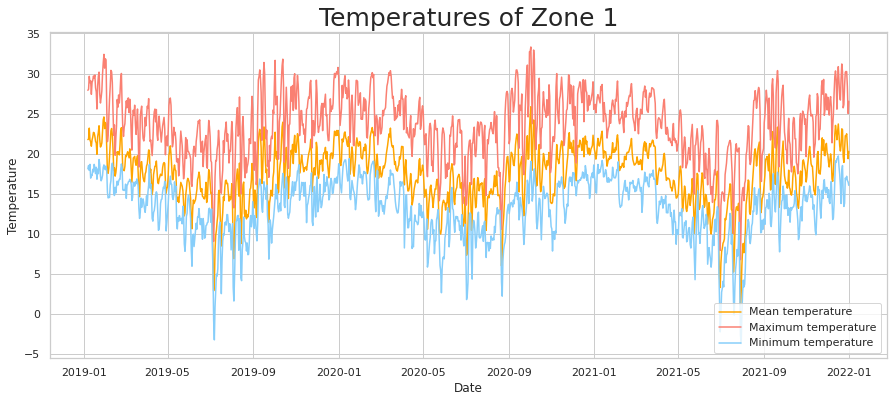

In [68]:
plot_temp(complete1,mean1,1)

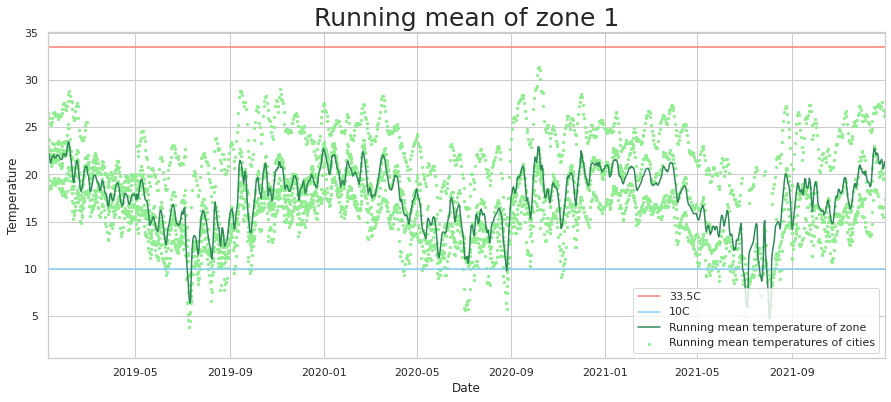

In [69]:
plot_scatter_temp(complete1,mean1,1)

In [70]:
get_pct(complete1)

above 10C and below 33.5C (%)  below 10C (%)  above 33.5C (%)
TMEAN                                 94.76           5.24             0.00
RUNNING_MEAN                          96.75           3.25             0.00
TMIN                                  78.17          21.83             0.00
TMAX                                  96.02           0.63             3.35

In [71]:
get_season(complete1)

Distribution of the running mean for each season


above 10C and below 33.5C (%)  below 10C (%)  above 33.5C (%)
Summer                          25.72           0.00              0.0
Autumn                          24.64           0.33              0.0
Winter                          19.96           2.79              0.0
Spring                          26.43           0.12              0.0

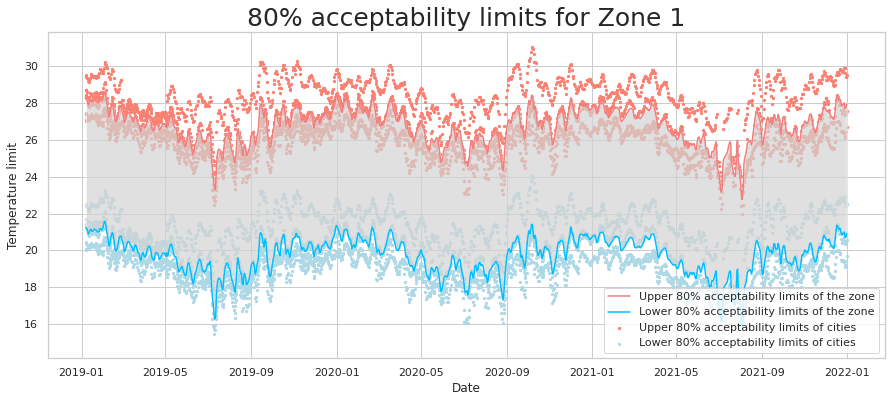

In [72]:
complete1 = get_limits(complete1,'RUNNING_MEAN')
mean1 = get_limits(mean1,'RUNNING_MEAN')

plot_limits_scatter(complete1,mean1,1)

In [73]:
mean1.describe()

TMAX        TMEAN         TMIN  RUNNING_MEAN     upper_80  \
count  1090.000000  1090.000000  1090.000000   1090.000000  1090.000000   
mean     23.658752    17.473240    13.223052     17.480034    26.718810   
std       4.043608     3.557966     3.704723      3.147039     0.975582   
min       6.800000     1.200000    -3.650000      4.700000    22.757000   
25%      21.300000    15.302083    11.277083     15.376250    26.066637   
50%      23.887500    17.888854    13.670833     18.100000    26.911000   
75%      26.619167    20.056748    16.100000     19.833333    27.448333   
max      33.320000    25.864167    19.733333     23.500000    28.585000   

          lower_80  
count  1090.000000  
mean     19.718810  
std       0.975582  
min      15.757000  
25%      19.066637  
50%      19.911000  
75%      20.448333  
max      21.585000

##**Zone 2**

In [74]:
complete2,mean2 = get_files(2)

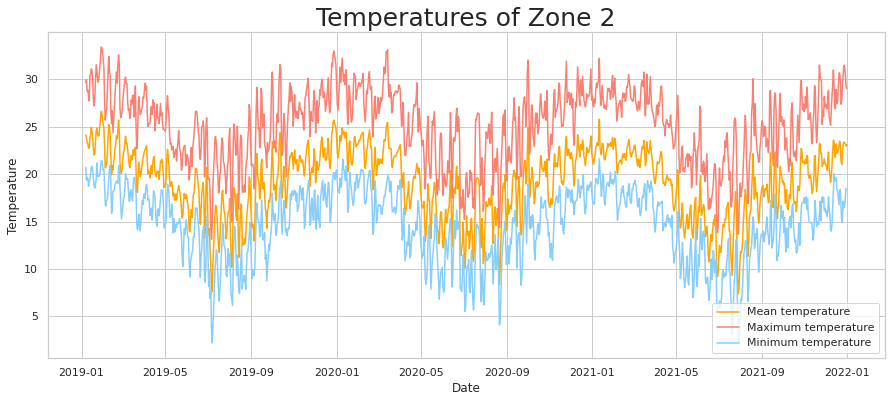

In [75]:
plot_temp(complete2,mean2,2)

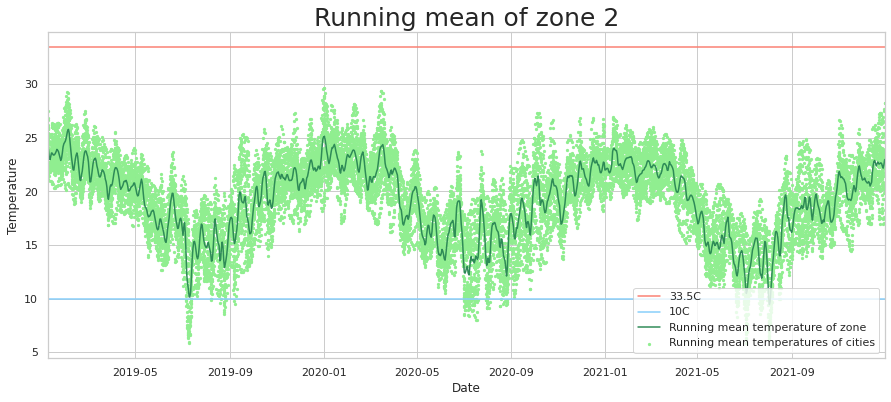

In [76]:
plot_scatter_temp(complete2,mean2,2)

In [77]:
get_pct(complete2)

above 10C and below 33.5C (%)  below 10C (%)  above 33.5C (%)
TMEAN                                 96.95           3.05             0.00
RUNNING_MEAN                          98.79           1.21             0.00
TMIN                                  85.04          14.96             0.00
TMAX                                  95.98           0.20             3.82

In [78]:
get_season(complete2)

Distribution of the running mean for each season


above 10C and below 33.5C (%)  below 10C (%)  above 33.5C (%)
Summer                          25.82           0.00              0.0
Autumn                          25.47           0.00              0.0
Winter                          22.76           1.20              0.0
Spring                          24.73           0.01              0.0

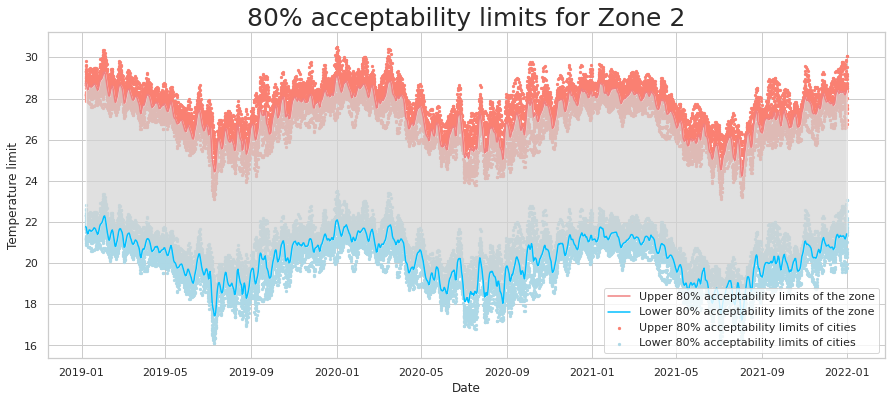

In [79]:
complete2 = get_limits(complete2,'RUNNING_MEAN')
mean2 = get_limits(mean2,'RUNNING_MEAN')

plot_limits_scatter(complete2,mean2,2)

In [80]:
mean2.describe()

TMAX        TMEAN         TMIN  RUNNING_MEAN     upper_80  \
count  1090.000000  1090.000000  1090.000000   1090.000000  1090.000000   
mean     25.209463    19.134343    14.654343     19.138140    27.232824   
std       3.813390     3.591106     3.768023      3.294661     1.021345   
min      13.142105     7.388542     2.143750      9.437500    24.225625   
25%      22.643158    16.701695    12.072566     16.701190    26.477369   
50%      25.866190    19.734814    15.082105     19.627381    27.384488   
75%      28.051915    21.940023    17.605882     21.887526    28.085133   
max      33.420000    26.633659    21.631818     25.795238    29.296524   

          lower_80  
count  1090.000000  
mean     20.232824  
std       1.021345  
min      17.225625  
25%      19.477369  
50%      20.384488  
75%      21.085133  
max      22.296524

##**Zone 3**

In [81]:
complete3,mean3 = get_files(3)

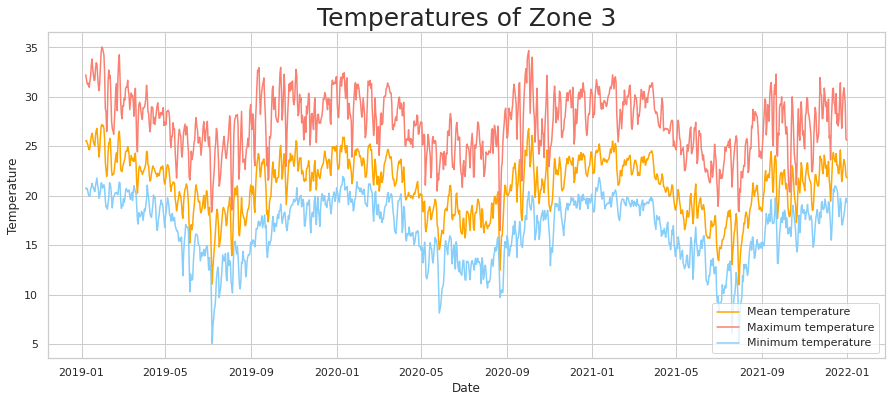

In [82]:
plot_temp(complete3,mean3,3)

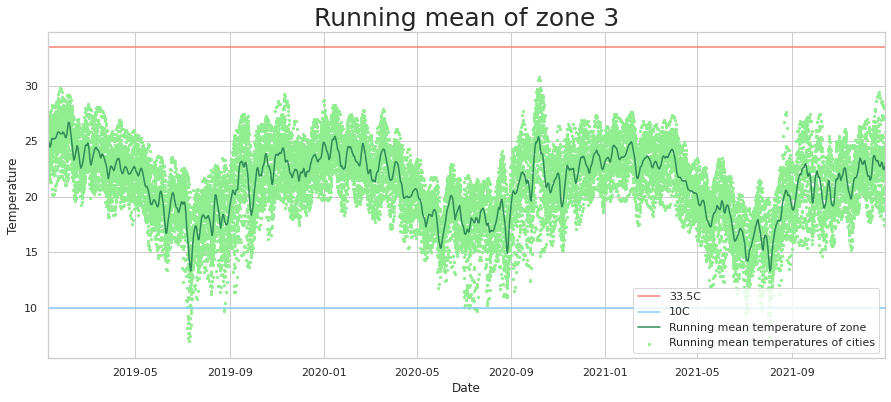

In [83]:
plot_scatter_temp(complete3,mean3,3)

In [84]:
get_pct(complete3)

above 10C and below 33.5C (%)  below 10C (%)  above 33.5C (%)
TMEAN                                 99.39           0.61             0.00
RUNNING_MEAN                          99.86           0.14             0.00
TMIN                                  94.46           5.54             0.00
TMAX                                  91.98           0.04             7.98

In [85]:
get_season(complete3)

Distribution of the running mean for each season


above 10C and below 33.5C (%)  below 10C (%)  above 33.5C (%)
Summer                          25.56           0.00              0.0
Autumn                          25.99           0.00              0.0
Winter                          24.40           0.14              0.0
Spring                          23.91           0.00              0.0

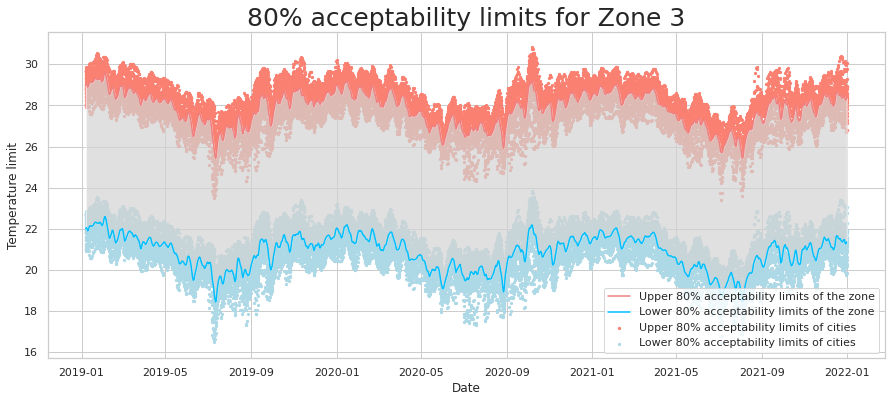

In [86]:
complete3 = get_limits(complete3,'RUNNING_MEAN')
mean3 = get_limits(mean3,'RUNNING_MEAN')

plot_limits_scatter(complete3,mean3,3)

In [87]:
mean3.describe()

TMAX        TMEAN         TMIN  RUNNING_MEAN     upper_80  \
count  1090.000000  1090.000000  1090.000000   1090.000000  1090.000000   
mean     27.366897    21.086045    16.712410     21.094633    27.839336   
std       3.005039     2.825288     3.117586      2.640976     0.818703   
min      16.508696    11.025076     5.084615     13.321053    25.429526   
25%      25.319886    18.921470    14.592888     19.111932    27.224699   
50%      27.507095    21.566214    17.417538     21.743561    28.040504   
75%      29.643375    23.311153    19.249500     23.176442    28.484697   
max      35.051852    27.215587    21.953571     26.707407    29.579296   

          lower_80  
count  1090.000000  
mean     20.839336  
std       0.818703  
min      18.429526  
25%      20.224699  
50%      21.040504  
75%      21.484697  
max      22.579296

##**Zone 4**

In [88]:
complete4,mean4 = get_files(4)

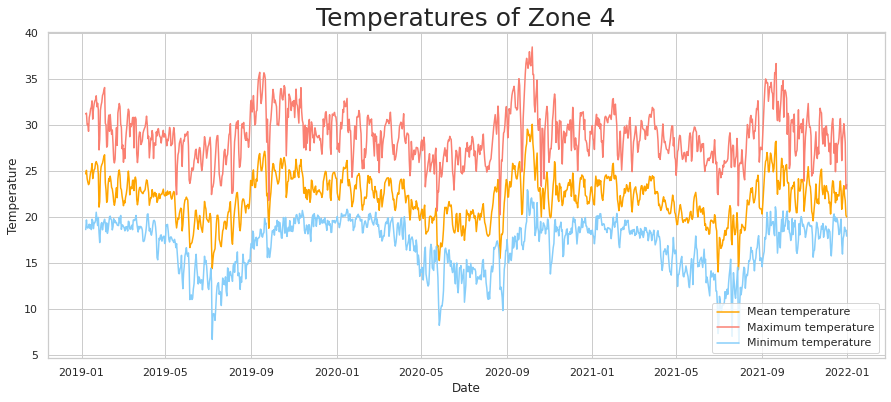

In [89]:
plot_temp(complete4,mean4,4)

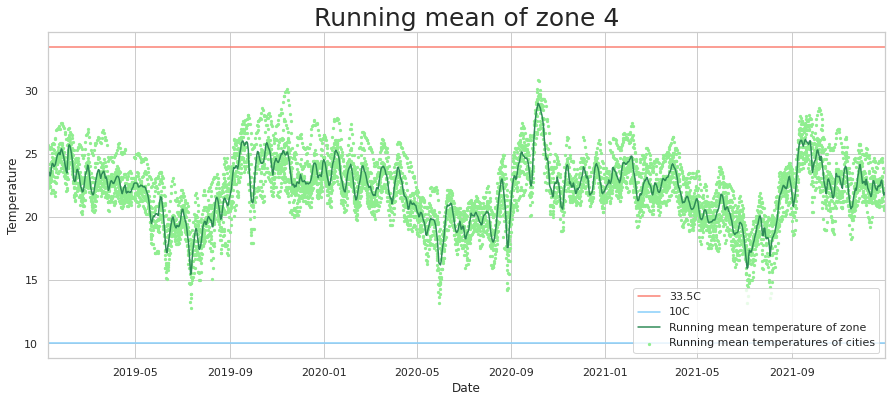

In [90]:
plot_scatter_temp(complete4,mean4,4)

In [91]:
get_pct(complete4)

above 10C and below 33.5C (%)  below 10C (%)  above 33.5C (%)
TMEAN                                 99.96           0.04             0.00
RUNNING_MEAN                         100.00           0.00             0.00
TMIN                                  97.23           2.77             0.00
TMAX                                  91.97           0.00             8.03

In [92]:
get_season(complete4)

Distribution of the running mean for each season


above 10C and below 33.5C (%)  below 10C (%)  above 33.5C (%)
Summer                          25.99            0.0              0.0
Autumn                          25.97            0.0              0.0
Winter                          24.59            0.0              0.0
Spring                          23.45            0.0              0.0

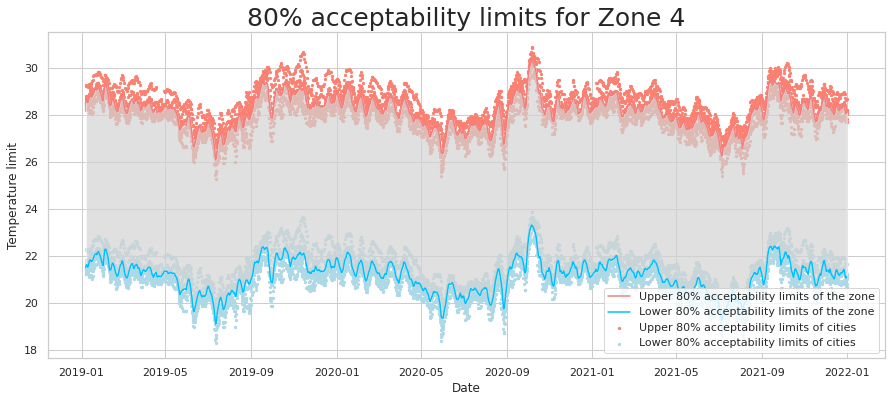

In [93]:
complete4 = get_limits(complete4,'RUNNING_MEAN')
mean4 = get_limits(mean4,'RUNNING_MEAN')

plot_limits_scatter(complete4,mean4,4)

In [94]:
mean4.describe()

TMAX        TMEAN         TMIN  RUNNING_MEAN     upper_80  \
count  1090.000000  1090.000000  1090.000000   1090.000000  1090.000000   
mean     28.841511    22.099897    16.939970     22.106596    28.153045   
std       2.695439     2.391458     2.752663      2.185732     0.677577   
min      20.200000    13.978977     6.200000     15.471429    26.096143   
25%      27.038839    20.511889    14.959524     20.572222    27.677389   
50%      28.750000    22.309821    17.914583     22.414583    28.248521   
75%      30.497222    23.796308    19.041518     23.542857    28.598286   
max      38.450000    30.042361    22.916667     29.033333    30.300333   

          lower_80  
count  1090.000000  
mean     21.153045  
std       0.677577  
min      19.096143  
25%      20.677389  
50%      21.248521  
75%      21.598286  
max      23.300333

##**Zone 5**

In [95]:
complete5,mean5 = get_files(5)

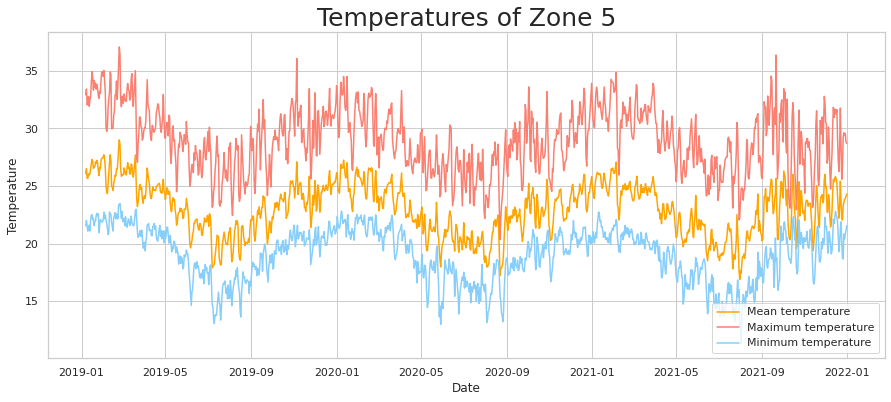

In [96]:
plot_temp(complete5,mean5,5)

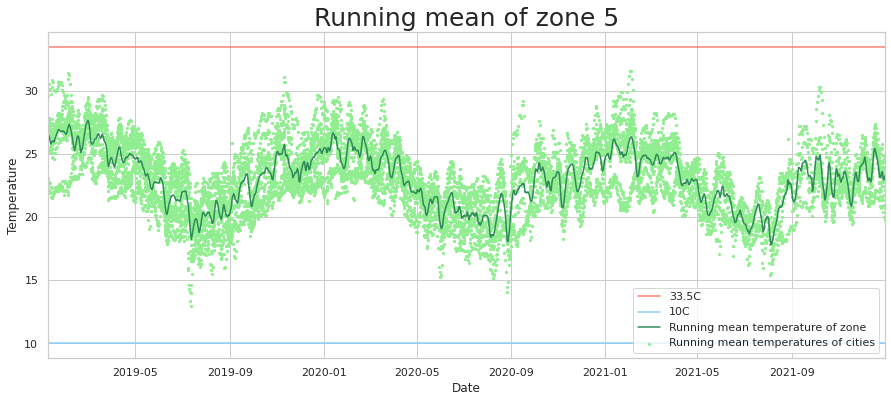

In [97]:
plot_scatter_temp(complete5,mean5,5)

In [98]:
get_pct(complete5)

above 10C and below 33.5C (%)  below 10C (%)  above 33.5C (%)
TMEAN                                 99.99           0.01             0.00
RUNNING_MEAN                         100.00           0.00             0.00
TMIN                                  99.45           0.55             0.00
TMAX                                  87.03           0.00            12.97

In [99]:
get_season(complete5)

Distribution of the running mean for each season


above 10C and below 33.5C (%)  below 10C (%)  above 33.5C (%)
Summer                          26.13            0.0              0.0
Autumn                          26.85            0.0              0.0
Winter                          24.28            0.0              0.0
Spring                          22.74            0.0              0.0

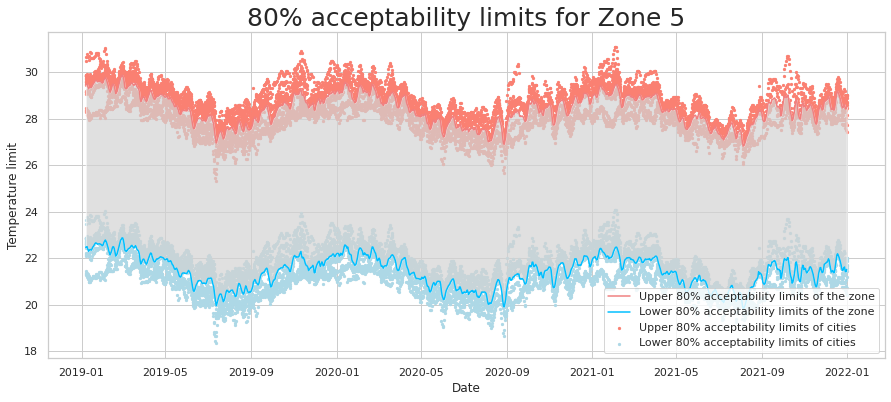

In [100]:
complete5 = get_limits(complete5,'RUNNING_MEAN')
mean5 = get_limits(mean5,'RUNNING_MEAN')

plot_limits_scatter(complete5,mean5,5)

In [101]:
mean5.describe()

TMAX        TMEAN         TMIN  RUNNING_MEAN     upper_80  \
count  1090.000000  1090.000000  1090.000000   1090.000000  1090.000000   
mean     28.977448    22.991727    19.021364     23.000922    28.430286   
std       2.769208     2.256666     2.308123      2.107779     0.653411   
min      20.363636    16.885417    11.316667     17.828571    26.826857   
25%      27.020357    21.329380    17.412188     21.375000    27.926250   
50%      28.988750    23.086806    19.452778     23.154545    28.477909   
75%      31.019918    24.692795    20.850000     24.698214    28.956446   
max      37.083333    29.007292    23.475000     27.666667    29.876667   

          lower_80  
count  1090.000000  
mean     21.430286  
std       0.653411  
min      19.826857  
25%      20.926250  
50%      21.477909  
75%      21.956446  
max      22.876667

##**Zone 6**

In [102]:
complete6,mean6 = get_files(6)

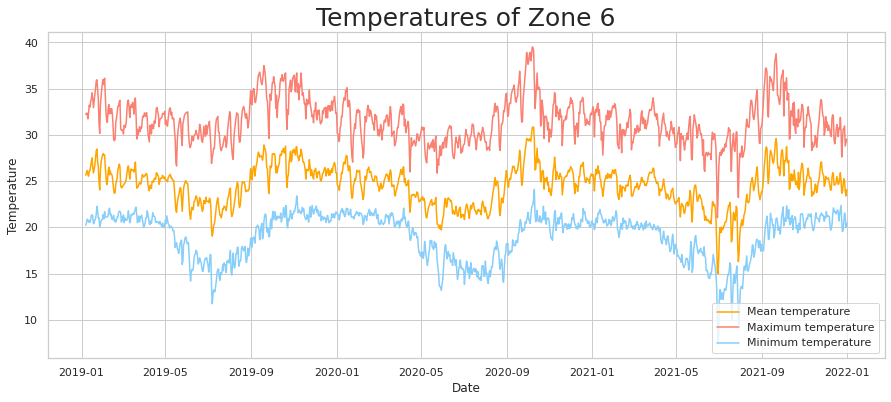

In [103]:
plot_temp(complete6,mean6,6)

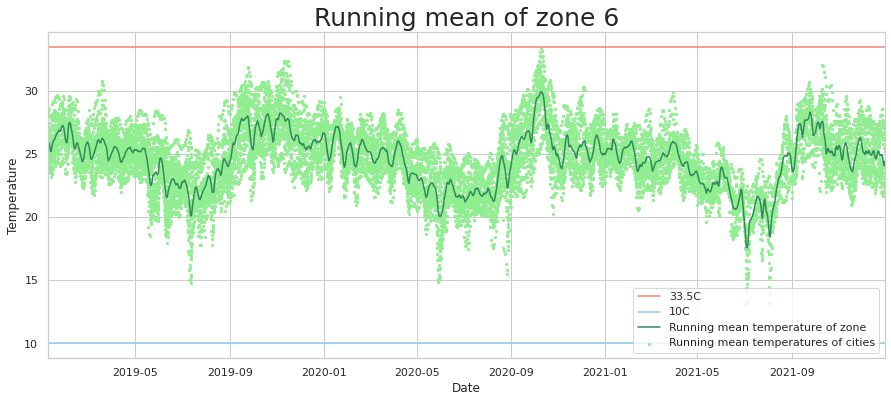

In [104]:
plot_scatter_temp(complete6,mean6,6)

In [105]:
get_pct(complete6)

above 10C and below 33.5C (%)  below 10C (%)  above 33.5C (%)
TMEAN                                 99.93           0.02             0.05
RUNNING_MEAN                         100.00           0.00             0.00
TMIN                                  99.17           0.83             0.00
TMAX                                  72.29           0.00            27.71

In [106]:
get_season(complete6)

Distribution of the running mean for each season


above 10C and below 33.5C (%)  below 10C (%)  above 33.5C (%)
Summer                          23.83            0.0              0.0
Autumn                          26.36            0.0              0.0
Winter                          24.85            0.0              0.0
Spring                          24.97            0.0              0.0

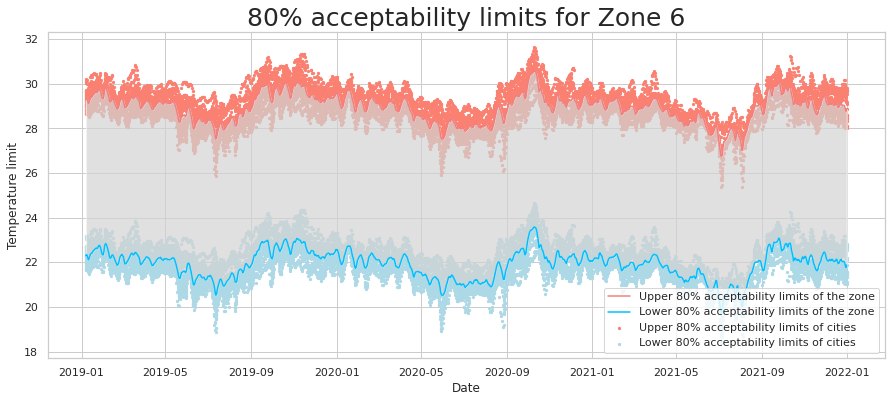

In [107]:
complete6 = get_limits(complete6,'RUNNING_MEAN')
mean6 = get_limits(mean6,'RUNNING_MEAN')

plot_limits_scatter(complete6,mean6,6)

In [108]:
mean6.describe()

TMAX        TMEAN         TMIN  RUNNING_MEAN     upper_80  \
count  1090.000000  1090.000000  1090.000000   1090.000000  1090.000000   
mean     31.538703    24.558507    19.098448     24.571096    28.917040   
std       2.393576     2.157389     2.521863      2.018394     0.625702   
min      21.036364    14.972337     7.430000     17.581818    26.750364   
25%      29.860294    23.116918    17.274845     23.112500    28.464875   
50%      31.416667    24.831504    20.155833     24.935504    29.030006   
75%      32.891369    25.915228    21.020000     25.858824    29.316235   
max      39.512500    30.845312    24.093750     29.950000    30.584500   

          lower_80  
count  1090.000000  
mean     21.917040  
std       0.625702  
min      19.750364  
25%      21.464875  
50%      22.030006  
75%      22.316235  
max      23.584500

##**Zone 7**

In [109]:
complete7,mean7 = get_files(7)

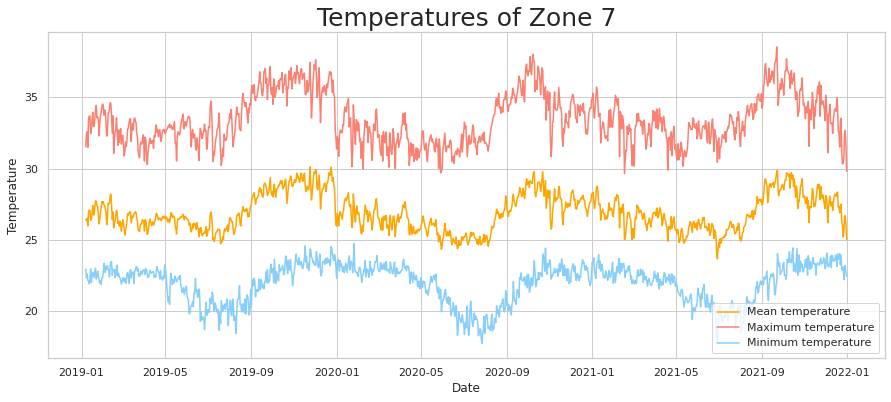

In [110]:
plot_temp(complete7,mean7,7)

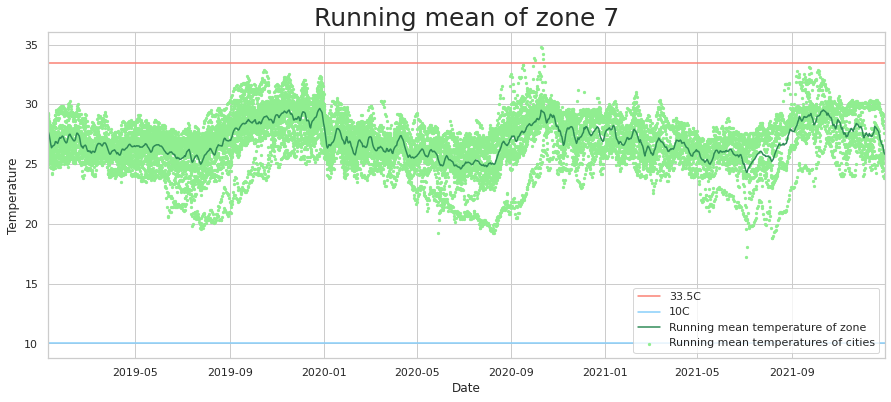

In [111]:
plot_scatter_temp(complete7,mean7,7)

In [112]:
get_pct(complete7)

above 10C and below 33.5C (%)  below 10C (%)  above 33.5C (%)
TMEAN                                 99.88           0.00             0.12
RUNNING_MEAN                          99.97           0.00             0.03
TMIN                                  99.99           0.01             0.00
TMAX                                  52.51           0.00            47.49

In [113]:
get_season(complete7)

Distribution of the running mean for each season


above 10C and below 33.5C (%)  below 10C (%)  above 33.5C (%)
Summer                          24.63            0.0             0.00
Autumn                          26.66            0.0             0.00
Winter                          25.21            0.0             0.00
Spring                          23.47            0.0             0.03

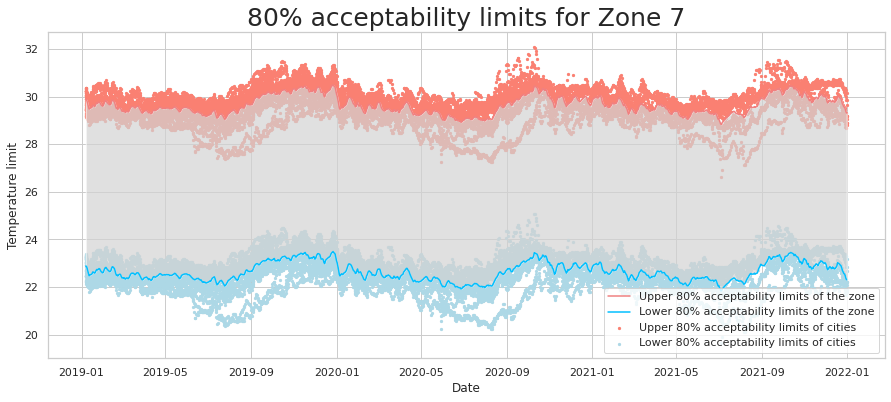

In [114]:
complete7 = get_limits(complete7,'RUNNING_MEAN')
mean7 = get_limits(mean7,'RUNNING_MEAN')

plot_limits_scatter(complete7,mean7,7)

In [115]:
mean7.describe()

TMAX        TMEAN         TMIN  RUNNING_MEAN     upper_80  \
count  1090.000000  1090.000000  1090.000000   1090.000000  1090.000000   
mean     33.451343    26.907932    21.944042     26.913579    29.643209   
std       1.760936     1.290216     1.371573      1.228058     0.380698   
min      29.637500    23.653219    17.704545     24.315385    28.837769   
25%      32.128409    25.911219    20.938393     26.010813    29.363352   
50%      33.182738    26.704898    22.329167     26.689583    29.573771   
75%      34.671250    27.862383    22.926250     27.879688    29.942703   
max      38.543750    30.120329    24.725000     29.656667    30.493567   

          lower_80  
count  1090.000000  
mean     22.643209  
std       0.380698  
min      21.837769  
25%      22.363352  
50%      22.573771  
75%      22.942703  
max      23.493567

##**Zone 8**

In [116]:
complete8,mean8 = get_files(8)

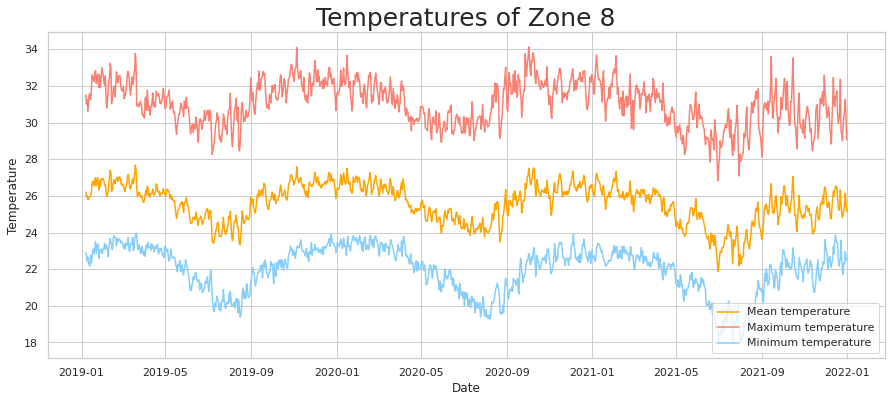

In [117]:
plot_temp(complete8,mean8,8)

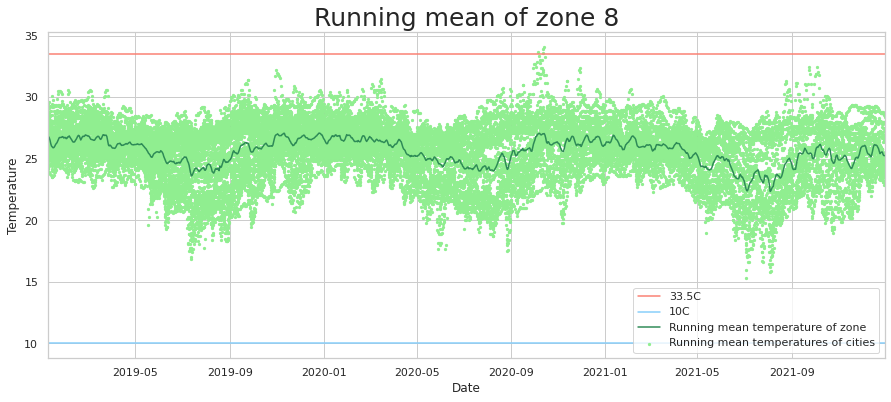

In [118]:
plot_scatter_temp(complete8,mean8,8)

In [119]:
get_pct(complete8)

above 10C and below 33.5C (%)  below 10C (%)  above 33.5C (%)
TMEAN                                 99.96           0.00             0.04
RUNNING_MEAN                          99.99           0.00             0.01
TMIN                                  99.92           0.08             0.00
TMAX                                  79.73           0.00            20.27

In [120]:
get_season(complete8)

Distribution of the running mean for each season


above 10C and below 33.5C (%)  below 10C (%)  above 33.5C (%)
Summer                          26.29            0.0             0.00
Autumn                          27.17            0.0             0.00
Winter                          23.90            0.0             0.00
Spring                          22.63            0.0             0.01

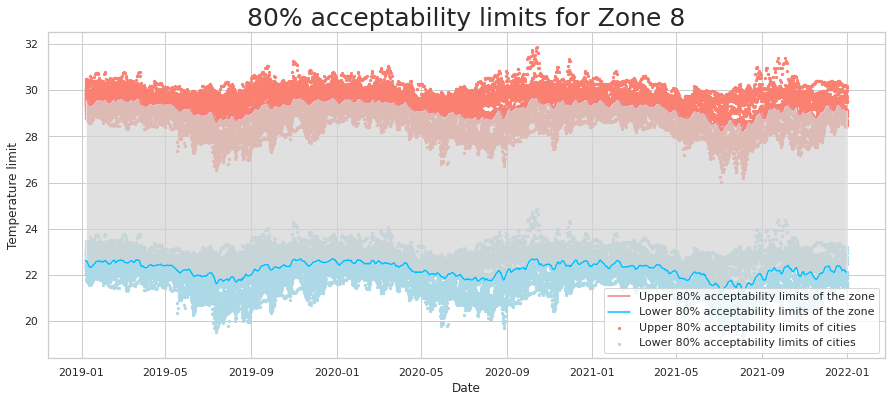

In [121]:
complete8 = get_limits(complete8,'RUNNING_MEAN')
mean8 = get_limits(mean8,'RUNNING_MEAN')

plot_limits_scatter(complete8,mean8,8)

In [122]:
mean8.describe()

TMAX        TMEAN         TMIN  RUNNING_MEAN     upper_80  \
count  1090.000000  1090.000000  1090.000000   1090.000000  1090.000000   
mean     31.036151    25.584678    21.984384     25.585242    29.231425   
std       1.201537     1.053740     1.261530      1.009254     0.312869   
min      26.832000    21.876667    17.944000     22.357692    28.230885   
25%      30.180408    24.843658    21.182414     24.890676    29.016110   
50%      31.107670    25.802957    22.282708     25.826250    29.306137   
75%      31.986801    26.386966    23.002830     26.386167    29.479712   
max      34.131034    27.679167    23.965385     27.101852    29.701574   

          lower_80  
count  1090.000000  
mean     22.231425  
std       0.312869  
min      21.230885  
25%      22.016110  
50%      22.306137  
75%      22.479712  
max      22.701574

##**Subplots**

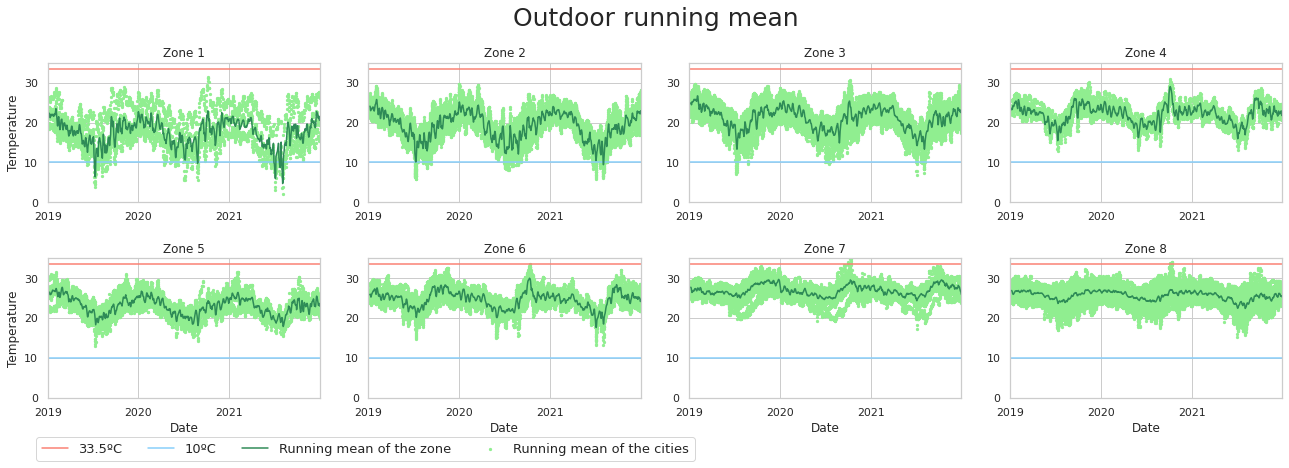

In [169]:
#create fig and set title
fig, ax = plt.subplots(figsize=(18, 6),nrows=2,ncols=4)
fig.suptitle("Outdoor running mean", fontsize = 25)
fig.tight_layout()
fig.subplots_adjust(top=0.85,hspace=0.4)

for i in range(2):
  for j in range(4):
    ax[i,j].set_xlim(mean1.DATE.iloc[0], mean1.DATE.iloc[-1])
    ax[i,j].set_ylim(0,35)
    ax[i,j].axhline(33.5,color='salmon',label = '33.5ºC')
    ax[i,j].axhline(10,color='lightskyblue',label = '10ºC')
    ax[i,j].set_xticks([dt.datetime(2019,1,1),dt.datetime(2020,1,1),dt.datetime(2021,1,1)])
    date_form = DateFormatter("%Y")
    ax[i,j].xaxis.set_major_formatter(date_form)

ax[0,0].scatter(complete1['DATE'],complete1['RUNNING_MEAN'],s=5,color='lightgreen',label='Running mean of the cities')
ax[0,0].plot(mean1['DATE'],mean1['RUNNING_MEAN'],color='seagreen',label='Running mean of the zone')
ax[0,0].set_title('Zone 1')

ax[0,1].scatter(complete2['DATE'],complete2['RUNNING_MEAN'],s=5,color='lightgreen',label='Running mean of the cities')
ax[0,1].plot(mean2['DATE'],mean2['RUNNING_MEAN'],color='seagreen',label='Running mean of the zone')
ax[0,1].set_title('Zone 2')

ax[0,2].scatter(complete3['DATE'],complete3['RUNNING_MEAN'],s=5,color='lightgreen',label='Running mean of the cities')
ax[0,2].plot(mean3['DATE'],mean3['RUNNING_MEAN'],color='seagreen',label='Running mean of the zone')
ax[0,2].set_title('Zone 3')

ax[0,3].scatter(complete4['DATE'],complete4['RUNNING_MEAN'],s=5,color='lightgreen',label='Running mean of the cities')
ax[0,3].plot(mean4['DATE'],mean4['RUNNING_MEAN'],color='seagreen',label='Running mean of the zone')
ax[0,3].set_title('Zone 4')

ax[1,0].scatter(complete5['DATE'],complete5['RUNNING_MEAN'],s=5,color='lightgreen',label='Running mean of the cities')
ax[1,0].plot(mean5['DATE'],mean5['RUNNING_MEAN'],color='seagreen',label='Running mean of the zone')
ax[1,0].set_title('Zone 5')

ax[1,1].scatter(complete6['DATE'],complete6['RUNNING_MEAN'],s=5,color='lightgreen',label='Running mean of the cities')
ax[1,1].plot(mean6['DATE'],mean6['RUNNING_MEAN'],color='seagreen',label='Running mean of the zone')
ax[1,1].set_title('Zone 6')

ax[1,2].scatter(complete7['DATE'],complete7['RUNNING_MEAN'],s=5,color='lightgreen',label='Running mean of the cities')
ax[1,2].plot(mean7['DATE'],mean7['RUNNING_MEAN'],color='seagreen',label='Running mean of the zone')
ax[1,2].set_title('Zone 7')

ax[1,3].scatter(complete8['DATE'],complete8['RUNNING_MEAN'],s=5,color='lightgreen',label='Running mean of the cities')
ax[1,3].plot(mean8['DATE'],mean8['RUNNING_MEAN'],color='seagreen',label='Running mean of the zone')
ax[1,3].set_title('Zone 8')

plt.legend(loc='lower left',bbox_to_anchor=(-3.6, -0.5),ncol=4,fontsize=13)
# set labels
plt.setp(ax[-1,:], xlabel='Date')
plt.setp(ax[:,0], ylabel='Temperature')
plt.show()

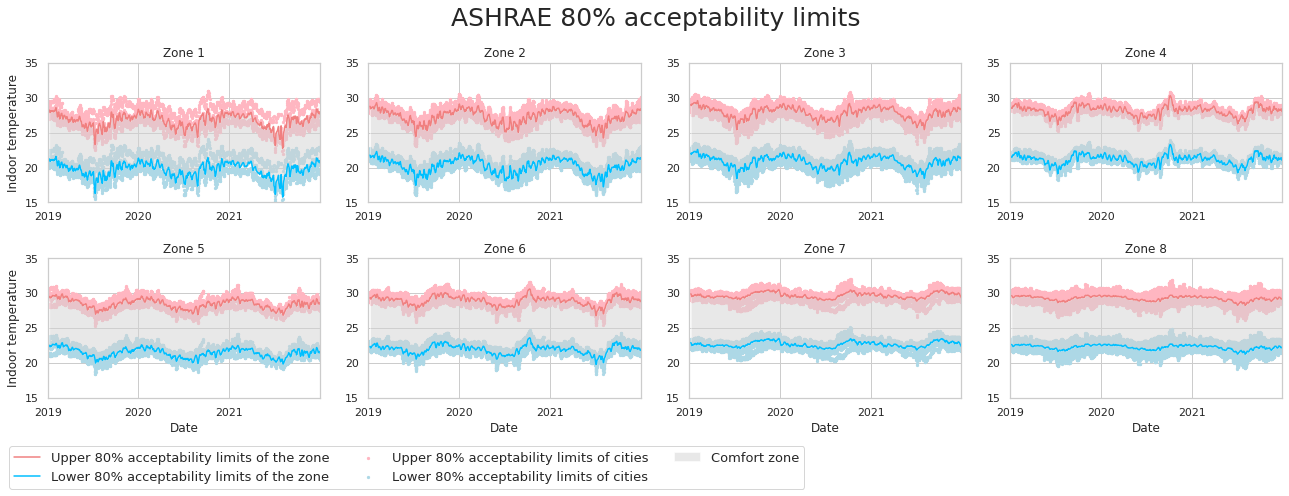

In [181]:
#create fig and set title
fig, ax = plt.subplots(figsize=(18, 6),nrows=2,ncols=4)
fig.suptitle("ASHRAE 80% acceptability limits", fontsize = 25)
fig.tight_layout()
fig.subplots_adjust(top=0.85,hspace=0.4)

for i in range(2):
  for j in range(4):
    ax[i,j].set_xlim(mean1.DATE.iloc[0], mean1.DATE.iloc[-1])
    ax[i,j].set_ylim(15,35)
    ax[i,j].set_xticks([dt.datetime(2019,1,1),dt.datetime(2020,1,1),dt.datetime(2021,1,1)])
    date_form = DateFormatter("%Y")
    ax[i,j].xaxis.set_major_formatter(date_form)

ax[0,0].scatter(complete1['DATE'], complete1['upper_80'], color='lightpink',s=5,label='Upper 80% acceptability limits of cities')
ax[0,0].scatter(complete1['DATE'], complete1['lower_80'], color='lightblue',s=5,label='Lower 80% acceptability limits of cities')
ax[0,0].plot(mean1['DATE'], mean1['upper_80'], color='lightcoral',label='Upper 80% acceptability limits of the zone')
ax[0,0].plot(mean1['DATE'], mean1['lower_80'], color='deepskyblue',label='Lower 80% acceptability limits of the zone')
d = mean1['DATE'].values
ax[0,0].fill_between(d, mean1['upper_80'], mean1['lower_80'],
                where=mean1['upper_80'] >= mean1['lower_80'],
                facecolor='lightgray',alpha=0.5)
ax[0,0].set_title('Zone 1')

ax[0,1].scatter(complete2['DATE'], complete2['upper_80'], color='lightpink',s=5,label='Upper 80% acceptability limits of cities')
ax[0,1].scatter(complete2['DATE'], complete2['lower_80'], color='lightblue',s=5,label='Lower 80% acceptability limits of cities')
ax[0,1].plot(mean2['DATE'], mean2['upper_80'], color='lightcoral',label='Upper 80% acceptability limits of the zone')
ax[0,1].plot(mean2['DATE'], mean2['lower_80'], color='deepskyblue',label='Lower 80% acceptability limits of the zone')
d = mean2['DATE'].values
ax[0,1].fill_between(d, mean2['upper_80'], mean2['lower_80'],
                where=mean2['upper_80'] >= mean2['lower_80'],
                facecolor='lightgray',alpha=0.5)
ax[0,1].set_title('Zone 2')

ax[0,2].scatter(complete3['DATE'], complete3['upper_80'], color='lightpink',s=5,label='Upper 80% acceptability limits of cities')
ax[0,2].scatter(complete3['DATE'], complete3['lower_80'], color='lightblue',s=5,label='Lower 80% acceptability limits of cities')
ax[0,2].plot(mean3['DATE'], mean3['upper_80'], color='lightcoral',label='Upper 80% acceptability limits of the zone')
ax[0,2].plot(mean3['DATE'], mean3['lower_80'], color='deepskyblue',label='Lower 80% acceptability limits of the zone')
d = mean3['DATE'].values
ax[0,2].fill_between(d, mean3['upper_80'], mean3['lower_80'],
                where=mean3['upper_80'] >= mean3['lower_80'],
                facecolor='lightgray',alpha=0.5)
ax[0,2].set_title('Zone 3')

ax[0,3].scatter(complete4['DATE'], complete4['upper_80'], color='lightpink',s=5,label='Upper 80% acceptability limits of cities')
ax[0,3].scatter(complete4['DATE'], complete4['lower_80'], color='lightblue',s=5,label='Lower 80% acceptability limits of cities')
ax[0,3].plot(mean4['DATE'], mean4['upper_80'], color='lightcoral',label='Upper 80% acceptability limits of the zone')
ax[0,3].plot(mean4['DATE'], mean4['lower_80'], color='deepskyblue',label='Lower 80% acceptability limits of the zone')
d = mean4['DATE'].values
ax[0,3].fill_between(d, mean4['upper_80'], mean4['lower_80'],
                where=mean4['upper_80'] >= mean4['lower_80'],
                facecolor='lightgray',alpha=0.5)
ax[0,3].set_title('Zone 4')

ax[1,0].scatter(complete5['DATE'], complete5['upper_80'], color='lightpink',s=5,label='Upper 80% acceptability limits of cities')
ax[1,0].scatter(complete5['DATE'], complete5['lower_80'], color='lightblue',s=5,label='Lower 80% acceptability limits of cities')
ax[1,0].plot(mean5['DATE'], mean5['upper_80'], color='lightcoral',label='Upper 80% acceptability limits of the zone')
ax[1,0].plot(mean5['DATE'], mean5['lower_80'], color='deepskyblue',label='Lower 80% acceptability limits of the zone')
d = mean5['DATE'].values
ax[1,0].fill_between(d, mean5['upper_80'], mean5['lower_80'],
                where=mean5['upper_80'] >= mean5['lower_80'],
                facecolor='lightgray',alpha=0.5)
ax[1,0].set_title('Zone 5')

ax[1,1].scatter(complete6['DATE'], complete6['upper_80'], color='lightpink',s=5,label='Upper 80% acceptability limits of cities')
ax[1,1].scatter(complete6['DATE'], complete6['lower_80'], color='lightblue',s=5,label='Lower 80% acceptability limits of cities')
ax[1,1].plot(mean6['DATE'], mean6['upper_80'], color='lightcoral',label='Upper 80% acceptability limits of the zone')
ax[1,1].plot(mean6['DATE'], mean6['lower_80'], color='deepskyblue',label='Lower 80% acceptability limits of the zone')
d = mean6['DATE'].values
ax[1,1].fill_between(d, mean6['upper_80'], mean6['lower_80'],
                where=mean6['upper_80'] >= mean6['lower_80'],
                facecolor='lightgray',alpha=0.5)
ax[1,1].set_title('Zone 6')

ax[1,2].scatter(complete7['DATE'], complete7['upper_80'], color='lightpink',s=5,label='Upper 80% acceptability limits of cities')
ax[1,2].scatter(complete7['DATE'], complete7['lower_80'], color='lightblue',s=5,label='Lower 80% acceptability limits of cities')
ax[1,2].plot(mean7['DATE'], mean7['upper_80'], color='lightcoral',label='Upper 80% acceptability limits of the zone')
ax[1,2].plot(mean7['DATE'], mean7['lower_80'], color='deepskyblue',label='Lower 80% acceptability limits of the zone')
d = mean7['DATE'].values
ax[1,2].fill_between(d, mean7['upper_80'], mean7['lower_80'],
                where=mean7['upper_80'] >= mean7['lower_80'],
                facecolor='lightgray',alpha=0.5)
ax[1,2].set_title('Zone 7')

ax[1,3].scatter(complete8['DATE'], complete8['upper_80'], color='lightpink',s=5,label='Upper 80% acceptability limits of cities')
ax[1,3].scatter(complete8['DATE'], complete8['lower_80'], color='lightblue',s=5,label='Lower 80% acceptability limits of cities')
ax[1,3].plot(mean8['DATE'], mean8['upper_80'], color='lightcoral',label='Upper 80% acceptability limits of the zone')
ax[1,3].plot(mean8['DATE'], mean8['lower_80'], color='deepskyblue',label='Lower 80% acceptability limits of the zone')
d = mean8['DATE'].values
ax[1,3].fill_between(d, mean8['upper_80'], mean8['lower_80'],
                where=mean8['upper_80'] >= mean8['lower_80'],
                facecolor='lightgray',alpha=0.5,label='Comfort zone')
ax[1,3].set_title('Zone 8')

plt.legend(loc='lower left',bbox_to_anchor=(-3.7, -0.7),ncol=3,fontsize=13)
plt.setp(ax[-1,:], xlabel='Date')
plt.setp(ax[:,0], ylabel='Indoor temperature')
plt.show()

##**ASHRAE 55 vs ABNT NBR 15575-1 limits for thermal comfort**

In [123]:
dataframes_upper = [mean1,mean2,mean3,mean4,mean5,mean6,mean7]

for df in dataframes_upper:
  df['confort_M_upper'] = df['TMAX']
  df['confort_I_upper'] = df['TMAX'] - 2
  df['confort_S_upper'] = df['TMAX'] - 4

dataframes_lower = [mean1,mean2,mean3,mean4,mean5]

for df in dataframes_lower:
  df['confort_M_lower'] = df['TMIN']+3
  df['confort_I_lower'] = df['TMIN']+5
  df['confort_S_lower'] = df['TMIN']+7

mean8['confort_M_upper'] = mean8['TMAX']
mean8['confort_I_upper'] = mean8['TMAX'] - 2
mean8['confort_S_upper'] = mean8['TMAX'] - 4

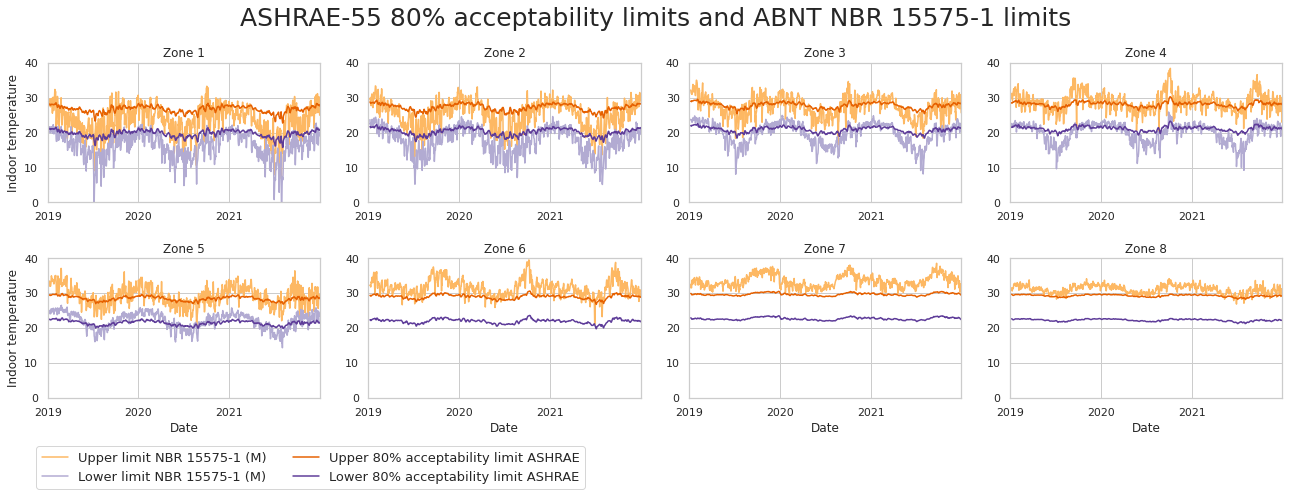

In [180]:
#create fig and set title
fig, ax = plt.subplots(figsize=(18, 6),nrows=2,ncols=4)
fig.suptitle("ASHRAE-55 80% acceptability limits and ABNT NBR 15575-1 limits", fontsize = 25)
fig.tight_layout()
fig.subplots_adjust(top=0.85,hspace=0.4)

for i in range(2):
  for j in range(4):
    ax[i,j].set_xlim(mean1.DATE.iloc[0], mean1.DATE.iloc[-1])
    ax[i,j].set_ylim(0,40)
    ax[i,j].set_xticks([dt.datetime(2019,1,1),dt.datetime(2020,1,1),dt.datetime(2021,1,1)])
    date_form = DateFormatter("%Y")
    ax[i,j].xaxis.set_major_formatter(date_form)

ax[0,0].plot(mean1['DATE'], mean1['confort_M_upper'], color='#fdb863',label='Upper limit NBR 15575-1 (M)')
ax[0,0].plot(mean1['DATE'], mean1['confort_M_lower'], color='#b2abd2',label='Lower limit NBR 15575-1 (M)')
ax[0,0].plot(mean1['DATE'], mean1['upper_80'], color='#e66101',label='Upper 80% acceptability limits of the zone')
ax[0,0].plot(mean1['DATE'], mean1['lower_80'], color='#5e3c99',label='Lower 80% acceptability limits of the zone')
ax[0,0].set_title('Zone 1')

ax[0,1].plot(mean2['DATE'], mean2['confort_M_upper'], color='#fdb863',label='Upper limit NBR 15575-1 (M)')
ax[0,1].plot(mean2['DATE'], mean2['confort_M_lower'], color='#b2abd2',label='Lower limit NBR 15575-1 (M)')
ax[0,1].plot(mean2['DATE'], mean2['upper_80'], color='#e66101',label='Upper 80% acceptability limits of the zone')
ax[0,1].plot(mean2['DATE'], mean2['lower_80'], color='#5e3c99',label='Lower 80% acceptability limits of the zone')
ax[0,1].set_title('Zone 2')

ax[0,2].plot(mean3['DATE'], mean3['confort_M_upper'], color='#fdb863',label='Upper limit NBR 15575-1 (M)')
ax[0,2].plot(mean3['DATE'], mean3['confort_M_lower'], color='#b2abd2',label='Lower limit NBR 15575-1 (M)')
ax[0,2].plot(mean3['DATE'], mean3['upper_80'], color='#e66101',label='Upper 80% acceptability limits of the zone')
ax[0,2].plot(mean3['DATE'], mean3['lower_80'], color='#5e3c99',label='Lower 80% acceptability limits of the zone')
d = mean3['DATE'].values
ax[0,2].set_title('Zone 3')

ax[0,3].plot(mean4['DATE'], mean4['confort_M_upper'], color='#fdb863',label='Upper limit NBR 15575-1 (M)')
ax[0,3].plot(mean4['DATE'], mean4['confort_M_lower'], color='#b2abd2',label='Lower limit NBR 15575-1 (M)')
ax[0,3].plot(mean4['DATE'], mean4['upper_80'], color='#e66101',label='Upper 80% acceptability limits of the zone')
ax[0,3].plot(mean4['DATE'], mean4['lower_80'], color='#5e3c99',label='Lower 80% acceptability limits of the zone')
ax[0,3].set_title('Zone 4')

ax[1,0].plot(mean5['DATE'], mean5['confort_M_upper'], color='#fdb863',label='Upper limit NBR 15575-1 (M)')
ax[1,0].plot(mean5['DATE'], mean5['confort_M_lower'], color='#b2abd2',label='Lower limit NBR 15575-1 (M)')
ax[1,0].plot(mean5['DATE'], mean5['upper_80'], color='#e66101',label='Upper 80% acceptability limits of the zone')
ax[1,0].plot(mean5['DATE'], mean5['lower_80'], color='#5e3c99',label='Lower 80% acceptability limits of the zone')
ax[1,0].set_title('Zone 5')

ax[1,1].plot(mean6['DATE'], mean6['confort_M_upper'], color='#fdb863',label='Upper limit NBR 15575-1 (M)')
ax[1,1].plot(mean6['DATE'], mean6['upper_80'], color='#e66101',label='Upper 80% acceptability limits of the zone')
ax[1,1].plot(mean6['DATE'], mean6['lower_80'], color='#5e3c99',label='Lower 80% acceptability limits of the zone')
ax[1,1].set_title('Zone 6')

ax[1,2].plot(mean7['DATE'], mean7['confort_M_upper'], color='#fdb863',label='Upper limit NBR 15575-1 (M)')
ax[1,2].plot(mean7['DATE'], mean7['upper_80'], color='#e66101',label='Upper 80% acceptability limits of the zone')
ax[1,2].plot(mean7['DATE'], mean7['lower_80'], color='#5e3c99',label='Lower 80% acceptability limits of the zone')
ax[1,2].set_title('Zone 7')

ax[1,3].plot(mean8['DATE'], mean8['confort_M_upper'], color='#fdb863',label='Upper limit NBR 15575-1 (M)')
ax[1,3].plot(mean8['DATE'], mean8['confort_M_upper']-100, color='#b2abd2', label='Lower limit NBR 15575-1 (M)') #fixing the legend
ax[1,3].plot(mean8['DATE'], mean8['upper_80'], color='#e66101',label='Upper 80% acceptability limit ASHRAE')
ax[1,3].plot(mean8['DATE'], mean8['lower_80'], color='#5e3c99',label='Lower 80% acceptability limit ASHRAE')
ax[1,3].set_title('Zone 8')

plt.legend(loc='lower left',bbox_to_anchor=(-3.6, -0.7),ncol=2,fontsize=13) 
plt.setp(ax[-1,:], xlabel='Date')
plt.setp(ax[:,0], ylabel='Indoor temperature')
plt.show()

##**Descriptives**

In [62]:
mean1 = mean1.rename(columns = {'RUNNING_MEAN':'RUNNING_MEAN_1','upper_80':'upper_1','lower_80':'lower_1',})
mean2 = mean2.rename(columns = {'RUNNING_MEAN':'RUNNING_MEAN_2','upper_80':'upper_2','lower_80':'lower_2',})
mean3 = mean3.rename(columns = {'RUNNING_MEAN':'RUNNING_MEAN_3','upper_80':'upper_3','lower_80':'lower_3',})
mean4 = mean4.rename(columns = {'RUNNING_MEAN':'RUNNING_MEAN_4','upper_80':'upper_4','lower_80':'lower_4',})
mean5 = mean5.rename(columns = {'RUNNING_MEAN':'RUNNING_MEAN_5','upper_80':'upper_5','lower_80':'lower_5',})
mean6 = mean6.rename(columns = {'RUNNING_MEAN':'RUNNING_MEAN_6','upper_80':'upper_6','lower_80':'lower_6',})
mean7 = mean7.rename(columns = {'RUNNING_MEAN':'RUNNING_MEAN_7','upper_80':'upper_7','lower_80':'lower_7',})
mean8 = mean8.rename(columns = {'RUNNING_MEAN':'RUNNING_MEAN_8','upper_80':'upper_8','lower_80':'lower_8',})

mean = pd.concat([mean1,mean2,mean3,mean4,mean5,mean6,mean7,mean8])

In [63]:
mean[['RUNNING_MEAN_1','RUNNING_MEAN_2','RUNNING_MEAN_3','RUNNING_MEAN_4',
'RUNNING_MEAN_5','RUNNING_MEAN_6','RUNNING_MEAN_7','RUNNING_MEAN_8']].describe()

RUNNING_MEAN_1  RUNNING_MEAN_2  RUNNING_MEAN_3  RUNNING_MEAN_4  \
count     1090.000000     1090.000000     1090.000000     1090.000000   
mean        17.480034       19.138140       21.094633       22.106596   
std          3.147039        3.294661        2.640976        2.185732   
min          4.700000        9.437500       13.321053       15.471429   
25%         15.376250       16.701190       19.111932       20.572222   
50%         18.100000       19.627381       21.743561       22.414583   
75%         19.833333       21.887526       23.176442       23.542857   
max         23.500000       25.795238       26.707407       29.033333   

       RUNNING_MEAN_5  RUNNING_MEAN_6  RUNNING_MEAN_7  RUNNING_MEAN_8  
count     1090.000000     1090.000000     1090.000000     1090.000000  
mean        23.000922       24.571096       26.913579       25.585242  
std          2.107779        2.018394        1.228058        1.009254  
min         17.828571       17.581818       24.315385       22.357692  
25%         21.375000       23.112500       26.010813       24.890676  
50%         23.154545       24.935504       26.689583       25.826250  
75%         24.698214       25.858824       27.879688       26.386167  
max         27.666667       29.950000       29.656667       27.101852

In [64]:
mean[['upper_1','upper_2','upper_3','upper_4','upper_5','upper_6','upper_7','upper_8']].describe()

upper_1      upper_2      upper_3      upper_4      upper_5  \
count  1090.000000  1090.000000  1090.000000  1090.000000  1090.000000   
mean     26.718810    27.232824    27.839336    28.153045    28.430286   
std       0.975582     1.021345     0.818703     0.677577     0.653411   
min      22.757000    24.225625    25.429526    26.096143    26.826857   
25%      26.066637    26.477369    27.224699    27.677389    27.926250   
50%      26.911000    27.384488    28.040504    28.248521    28.477909   
75%      27.448333    28.085133    28.484697    28.598286    28.956446   
max      28.585000    29.296524    29.579296    30.300333    29.876667   

           upper_6      upper_7      upper_8  
count  1090.000000  1090.000000  1090.000000  
mean     28.917040    29.643209    29.231425  
std       0.625702     0.380698     0.312869  
min      26.750364    28.837769    28.230885  
25%      28.464875    29.363352    29.016110  
50%      29.030006    29.573771    29.306137  
75%      29.316235    29.942703    29.479712  
max      30.584500    30.493567    29.701574

In [65]:
mean[['lower_1','lower_2','lower_3','lower_4','lower_5','lower_6','lower_7','lower_8']].describe()

lower_1      lower_2      lower_3      lower_4      lower_5  \
count  1090.000000  1090.000000  1090.000000  1090.000000  1090.000000   
mean     19.718810    20.232824    20.839336    21.153045    21.430286   
std       0.975582     1.021345     0.818703     0.677577     0.653411   
min      15.757000    17.225625    18.429526    19.096143    19.826857   
25%      19.066637    19.477369    20.224699    20.677389    20.926250   
50%      19.911000    20.384488    21.040504    21.248521    21.477909   
75%      20.448333    21.085133    21.484697    21.598286    21.956446   
max      21.585000    22.296524    22.579296    23.300333    22.876667   

           lower_6      lower_7      lower_8  
count  1090.000000  1090.000000  1090.000000  
mean     21.917040    22.643209    22.231425  
std       0.625702     0.380698     0.312869  
min      19.750364    21.837769    21.230885  
25%      21.464875    22.363352    22.016110  
50%      22.030006    22.573771    22.306137  
75%      22.316235    22.942703    22.479712  
max      23.584500    23.493567    22.701574